In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import numpyro
import math
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

from jax import random
from numpyro.infer import MCMC, NUTS

import numpyro.distributions as dist

import arviz as az

In [2]:
class Wind:
    def __init__(self, speed, direction):
        self.speed = speed # a function over time
        self.direction = direction # a tuple in the form of (x,y)

    def angle(self): # the angle between the velocity and the east-west direction
        theta = math.atan2(self.direction[1], self.direction[0])
        return theta
  
    def velocity(self):
        x = self.speed * math.cos(self.angle())
        y = self.speed * math.sin(self.angle())
        return (x,y)

In [3]:
class Signal:
    def __init__(self, N_p, lw, hi):
        self.input = np.random.uniform(low=lw, high=hi, size=2*N_p) # twice the pixels because the signal is moving

    def moving_velocity(self, wind):
        vel = wind.velocity()
        return vel

    def signal_func(self, time, wind, N_p): # one dimensional
        signal_t = []
        vel = self.moving_velocity(wind)[0]
        for i in range(N_p):
            signal_t.append(self.input[i-int(time*vel)])
        # print(vel, time, int(time*vel))
        signal_t = np.array(signal_t)
        return signal_t

In [4]:
class Data:
    def __init__(self, signal, PM1, PM2, size):
        self.signal = signal
        self.PM1 = PM1
        self.PM2 = PM2
        self.size = size
        self.input_1 = None
        self.input_2 = None

    def get_data_method_2(self):
        self.input_2 = self.signal[self.PM2]
        return self.input_2

    def add_small_noise(self):
        noise = np.random.randn(self.size) * 10
        if (self.input_1 is None):
            return self.input_2 + noise
        return self.input_1 + noise
    
    def add_large_noise(self):
        noise = np.random.randn(self.size) * 50
        if (self.input_1 is None):
            return self.input_2 + noise
        return self.input_1 + noise

In [5]:
# N_t: number of times data is detected by each detector; N_p: number of pixels
# signal: data of signal (which in this case is modeled to be a sine function in each pixel)
N_t, N_p = 150 * 10, 10

In [6]:
wind = Wind(0.5, (-1,0))
signal_pack = Signal(N_p, 5, 30)
signal = signal_pack.input

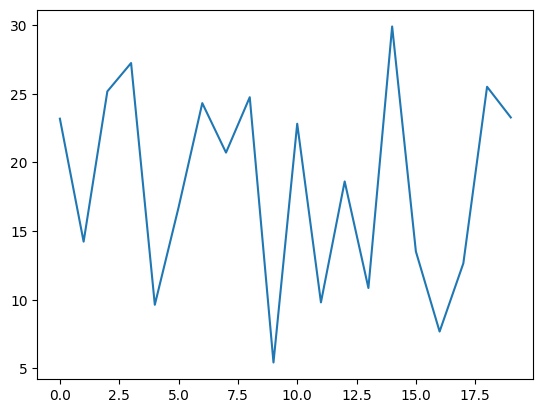

In [7]:
plt.plot(signal)

In [8]:
# the original pointing matrix
P_encoded_org = list()
for row in range(N_t):
    for col in range(N_p):
            if ((row / 150) // (10 / 10) == col):
                P_encoded_org.append(col)
          
P_encoded_org = np.array(P_encoded_org)
print(np.shape(P_encoded_org))

# the pointing matrix adjusted for the shifting signal
P_encoded = list()
for row in range(N_t):
    for col in range(N_p*2):
            if ((row / 150) // (10 / 20) == col):
                P_encoded.append(col)        
P_encoded = np.array(P_encoded)
print(np.shape(P_encoded))

(1500,)
(1500,)


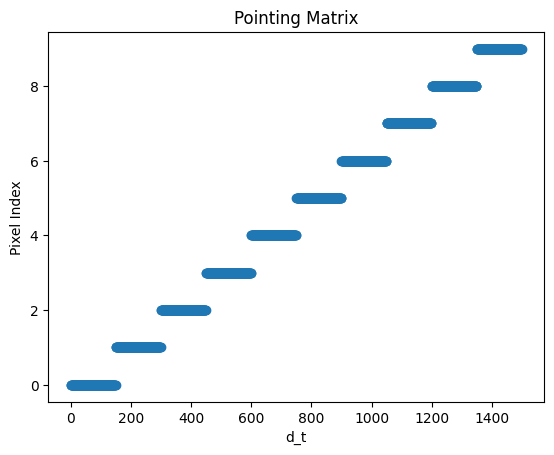

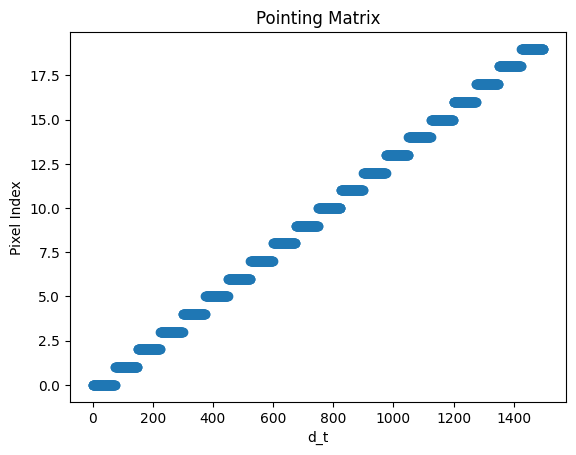

In [9]:
# check P_encoded

plt.scatter(range(len(P_encoded_org)), P_encoded_org)
plt.xlabel("d_t")
plt.ylabel("Pixel Index")
plt.title("Pointing Matrix")
plt.show()

plt.scatter(range(len(P_encoded)), P_encoded)
plt.xlabel("d_t")
plt.ylabel("Pixel Index")
plt.title("Pointing Matrix")
plt.show()

In [10]:
data_pack = Data(signal, P_encoded_org, P_encoded, N_t)

In [11]:
rng_key = random.PRNGKey(0)

Method 1 -- Make the signal in each pixel to a function over time

In [12]:
data_pack.input_2 = None

input_1 = []
for time_ind in range(N_t):
    output = signal_pack.signal_func(time_ind/150., wind, N_p)
    # print(np.shape(output))
    input_1.append(output[P_encoded_org][time_ind])
input_1 = np.array(input_1)

data_pack.input_1 = input_1

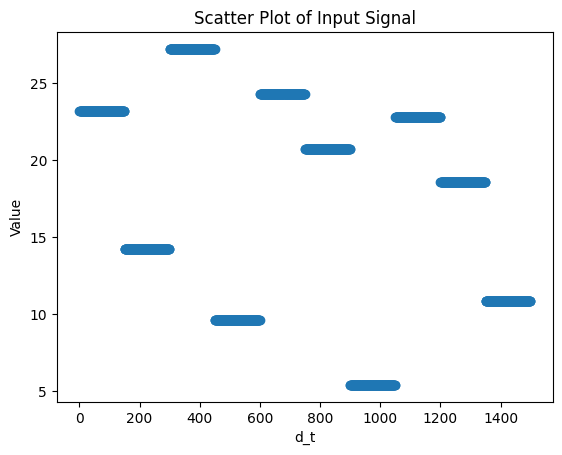

In [13]:
# Scatter Plot of Input Signals

plt.scatter(range(len(input_1)), input_1)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Input Signal")
plt.show()

In [14]:
Data_small_noise_1 = data_pack.add_small_noise()
Data_large_noise_1 = data_pack.add_large_noise()

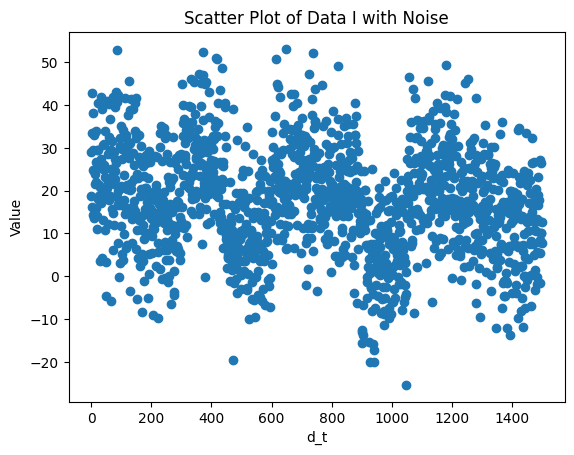

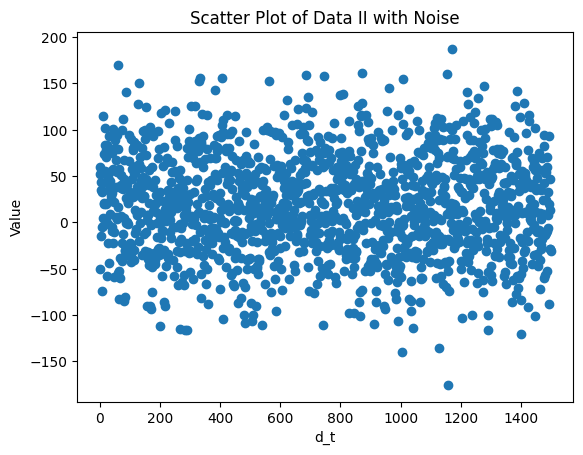

In [15]:
# Scatter Plot of Data

plt.scatter(range(len(Data_small_noise_1)), Data_small_noise_1)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data I with Noise")
plt.show()

plt.scatter(range(len(Data_large_noise_1)), Data_large_noise_1)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data II with Noise")
plt.show()

In [16]:
def sig_func_at_t_py(s,t,wind_speed):
    signal_t = []
    for i in range(N_p):
        signal_t.append(s[i-jnp.array(t*wind_speed, int)])
    # print(vel, time, int(time*vel))
    signal_t = jnp.array(signal_t)
    return signal_t

def sig_func_at_t_jax(s,t,wind_speed):
    shift = jnp.array(t * wind_speed, dtype=int)
    idx = jnp.arange(N_p) - shift
    signal_t = s[idx]
    return signal_t

In [26]:
from jax import vmap
def model_func_1():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p*2,-30), high=jnp.full(N_p*2,100)))

        wind_speed = numpyro.sample("speed", dist.Uniform(-100.0,100.0))
        
        # input = []
        # for time_ind in range(N_t):
        #         output = sig_func_at_t_py(s,time_ind/150., wind_speed)
        #         # print(np.shape(output))
        #         input.append(output[P_encoded_org][time_ind])
        # d = jnp.asarray(input)

        def step_fn(time_ind, s, wind_speed, P_encoded_org):
                t = time_ind / 150.0
                output = sig_func_at_t_jax(s, t, wind_speed)
                return output[P_encoded_org][time_ind]

        time_inds = jnp.arange(N_t)

        d = jax.vmap(lambda ti: step_fn(ti, s, wind_speed, P_encoded_org))(time_inds)

        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data_small_noise_1)

        # wind_speed = numpyro.sample("wind_speed", dist.Normal(wind_speed,1.), obs=Data_small_noise_1)

        return d_noised

nuts_kernel_1 = NUTS(model_func_1)
mcmc_1 = MCMC(nuts_kernel_1, num_warmup=1000, num_samples=1000)
mcmc_1.run(rng_key)

sample: 100%|██████████| 2000/2000 [1:25:19<00:00,  2.56s/it, 1023 steps of size 2.11e-04. acc. prob=0.90]    


In [27]:
samples   = mcmc_1.get_samples()
wind_speed_est = samples["speed"]
speed_mean_est = jnp.mean(wind_speed_est)
print(speed_mean_est)

39.75184


In [19]:
def model_func_2():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p,-30), high=jnp.full(N_p,100)))
        d = s[P_encoded_org]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,50.), obs=Data_large_noise_1)
        return d_noised

nuts_kernel_2 = NUTS(model_func_2)
mcmc_2 = MCMC(nuts_kernel_2, num_warmup=100, num_samples=100)
mcmc_2.run(rng_key)

(1500,)
(1500,)
(1500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(1500,)
(1500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 477.89it/s, 7 steps of size 5.89e-01. acc. prob=0.91]


In [28]:
trace_1 = az.from_numpyro(mcmc_1)
# trace_2 = az.from_numpyro(mcmc_2)

In [29]:
trace_1.posterior['s'].squeeze().shape
# trace_2.posterior['s'].squeeze().shape

(1000, 20)

In [ ]:
print()

In [30]:
signal_2 = []
for i in range(len(signal)):
    if ((i+1) % 3 != 0):
        signal_2.append(signal[i])

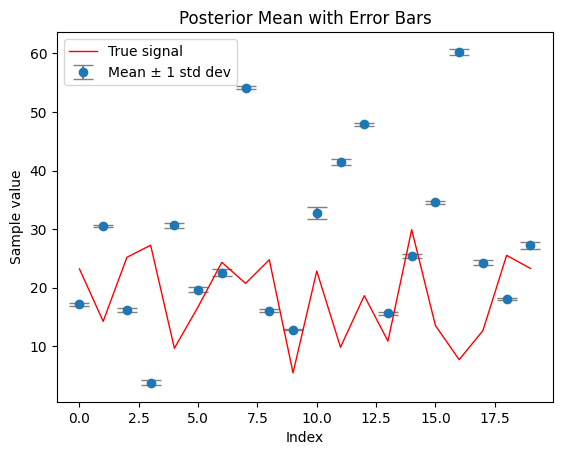

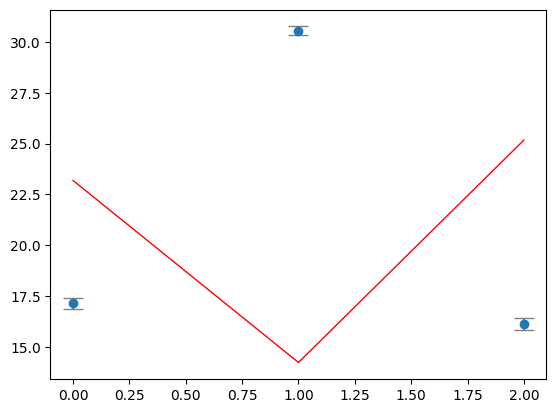

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_8846/1176418302.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


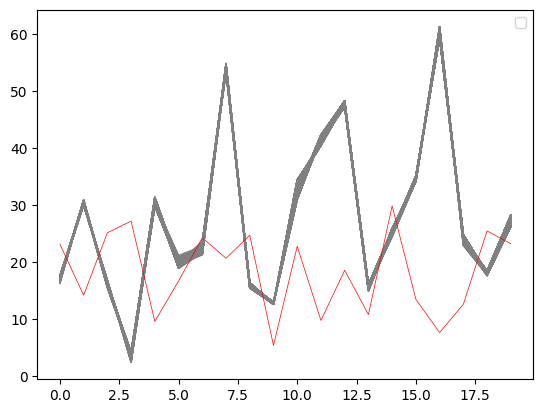

In [34]:
s_samples_1 = trace_1.posterior['s'].squeeze().values # shape: (num_of_samples, N_p)
s_mean_1 = np.mean(s_samples_1, axis=0) # shape: (N_p,)
s_std_1 = np.std(s_samples_1, axis=0) # shape: (N_p,)

x = np.arange(len(s_mean_1))

plt.errorbar(x, s_mean_1, yerr=s_std_1, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:3], s_mean_1[0:3], yerr=s_std_1[0:3], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal[0:3], color='red', lw=1, label='True signal')
plt.show()

for i in range(1000):
    plt.plot(trace_1.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

In [22]:
s_samples_2 = trace_2.posterior['s'].squeeze().values
s_mean_2 = np.mean(s_samples_2, axis=0)
s_std_2 = np.std(s_samples_2, axis=0)

x = np.arange(len(s_mean_2))

plt.errorbar(x, s_mean_2, yerr=s_std_2, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal_2, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:5], s_mean_2[0:5], yerr=s_std_2[0:5], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal_2[:5], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_2.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal_2, color='red', lw=0.5)
plt.legend()
plt.show()

NameError: name 'trace_2' is not defined

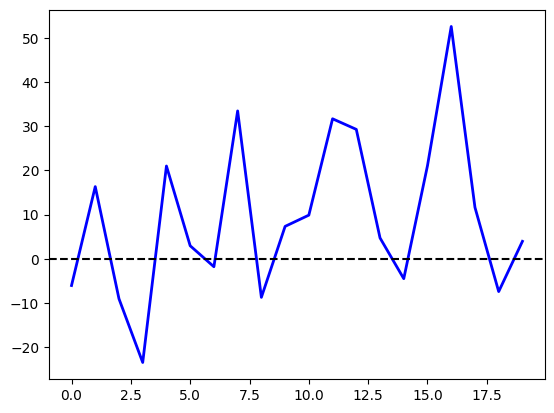

In [38]:
plt.plot(s_mean_1 - signal[:20], color='blue', lw=2.0)
plt.axhline(0, color='black', linestyle='--')
plt.show()

# plt.plot(s_mean_2 - signal_2[:10], color='blue', lw=2.0)
# plt.axhline(0, color='black', linestyle='--')
# plt.show()

Method 2 -- Frame a new set of pixels on the moving signal and take the relative speed of this new set of pixels with the detectors

In [55]:
input_2 = data_pack.get_data_method_2()
data_pack.input_1 = None

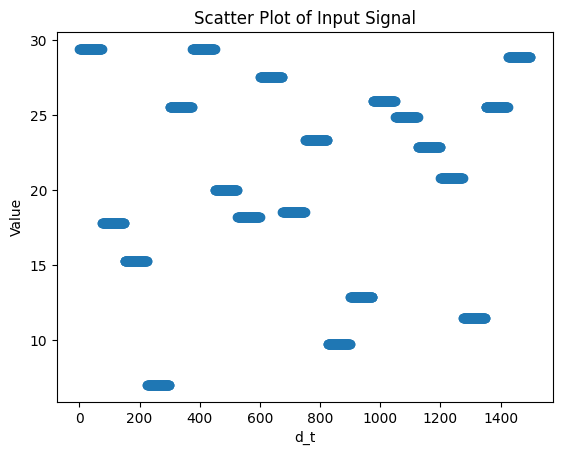

In [56]:
# Scatter Plot of Input Signals

plt.scatter(range(len(input_2)), input_2)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Input Signal")
plt.show()

In [57]:
Data_small_noise_2 = data_pack.add_small_noise()
Data_large_noise_2 = data_pack.add_large_noise()

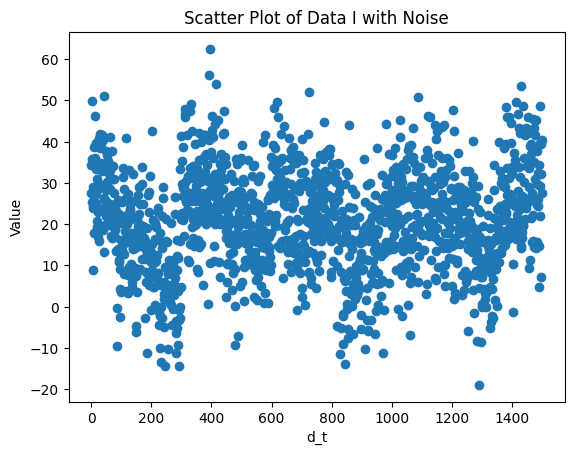

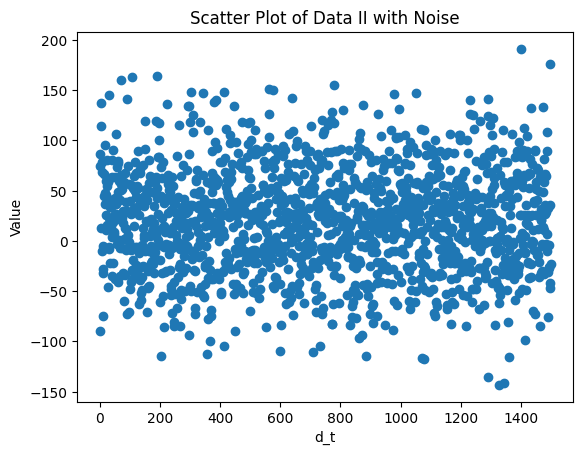

In [58]:
# Scatter Plot of Data

plt.scatter(range(len(Data_small_noise_2)), Data_small_noise_2)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data I with Noise")
plt.show()

plt.scatter(range(len(Data_large_noise_2)), Data_large_noise_2)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data II with Noise")
plt.show()

In [49]:
def model_func_3():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p*2,-30), high=jnp.full(N_p*2,100)))
        d = s[P_encoded]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data_small_noise_2)
        return d_noised

nuts_kernel_3 = NUTS(model_func_3)
mcmc_3 = MCMC(nuts_kernel_3, num_warmup=100, num_samples=100)
mcmc_3.run(rng_key)

(1500,)
(1500,)
(1500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(1500,)
(1500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 275.93it/s, 7 steps of size 5.49e-01. acc. prob=0.88] 


In [50]:
def model_func_4():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p*2,0), high=jnp.full(N_p*2,100)))
        # d = PM_converted @ s
        d = s[P_encoded]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,50.), obs=Data_large_noise_2)
        return d_noised

nuts_kernel_4 = NUTS(model_func_4)
mcmc_4 = MCMC(nuts_kernel_4, num_warmup=100, num_samples=100)
mcmc_4.run(rng_key)

(1500,)
(1500,)
(1500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(1500,)
(1500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 316.35it/s, 7 steps of size 6.87e-01. acc. prob=0.71]


In [51]:
trace_3 = az.from_numpyro(mcmc_3)
trace_4 = az.from_numpyro(mcmc_4)

(1500,)
(1500,)
(1500,)
(1500,)


In [52]:
trace_3.posterior['s'].squeeze().shape
trace_4.posterior['s'].squeeze().shape

(100, 20)

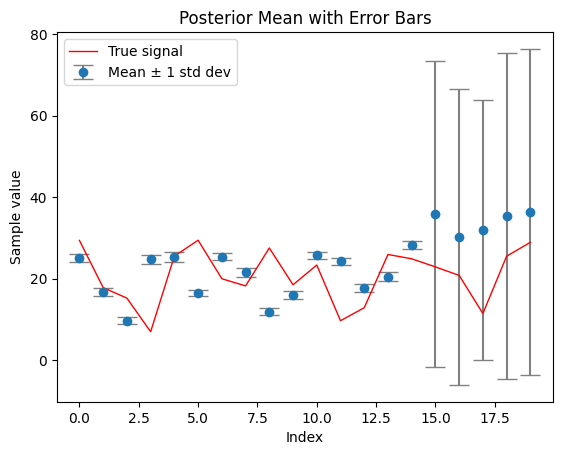

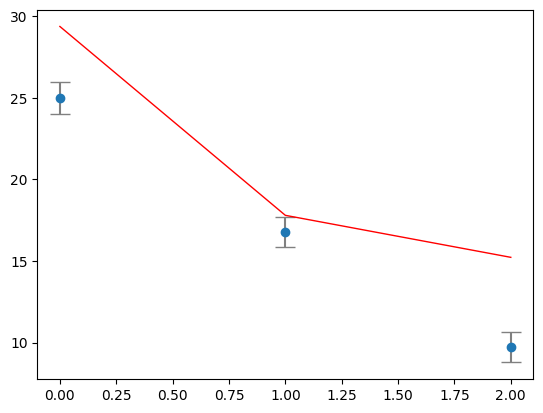

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_61912/1029122905.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


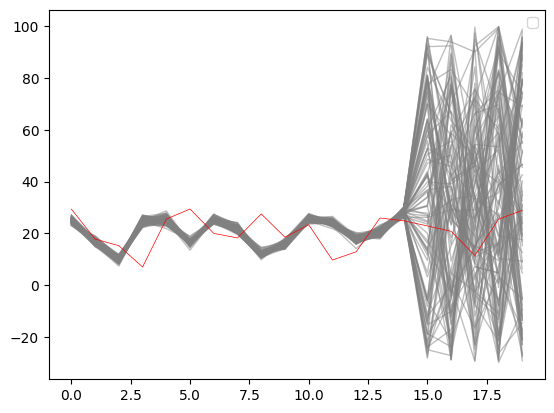

In [53]:
s_samples_3 = trace_3.posterior['s'].squeeze().values
s_mean_3 = np.mean(s_samples_3, axis=0)
s_std_3 = np.std(s_samples_3, axis=0)

x = np.arange(len(s_mean_3))

plt.errorbar(x, s_mean_3, yerr=s_std_3, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:3], s_mean_3[0:3], yerr=s_std_3[0:3], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal[0:3], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_3.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

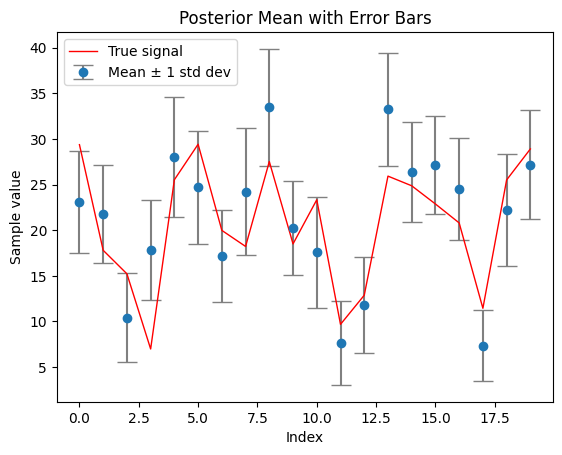

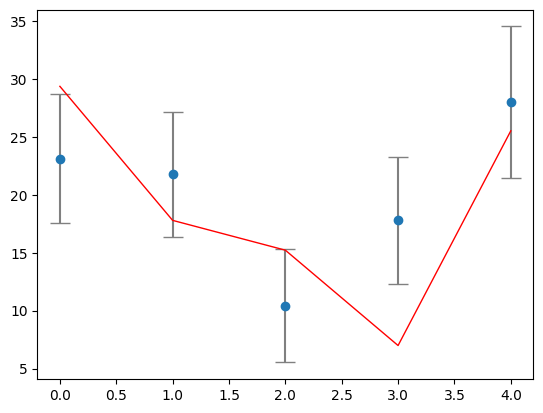

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_61912/777185513.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


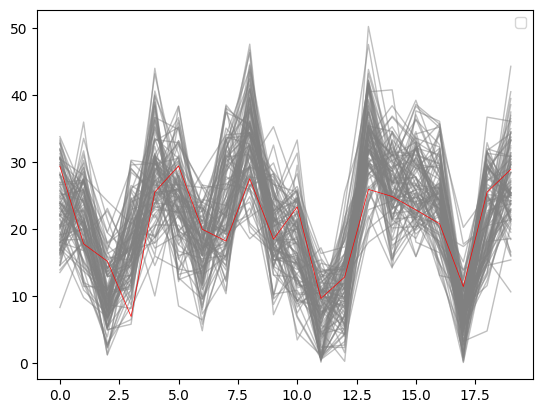

In [39]:
s_samples_4 = trace_4.posterior['s'].squeeze().values
s_mean_4 = np.mean(s_samples_4, axis=0)
s_std_4 = np.std(s_samples_4, axis=0)

x = np.arange(len(s_mean_4))

plt.errorbar(x, s_mean_4, yerr=s_std_4, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:5], s_mean_4[0:5], yerr=s_std_4[0:5], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal[:5], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_4.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

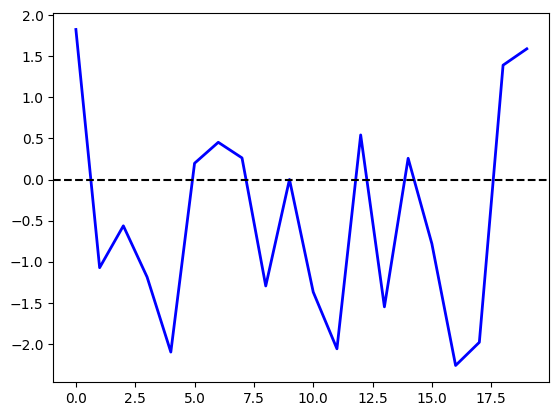

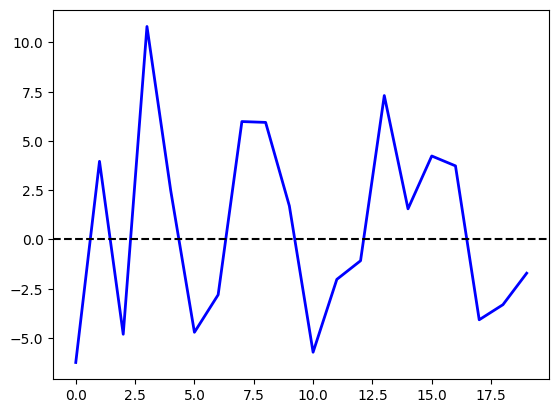

In [40]:
plt.plot(s_mean_3 - signal, color='blue', lw=2.0)
plt.axhline(0, color='black', linestyle='--')
plt.show()

plt.plot(s_mean_4 - signal, color='blue', lw=2.0)
plt.axhline(0, color='black', linestyle='--')
plt.show()

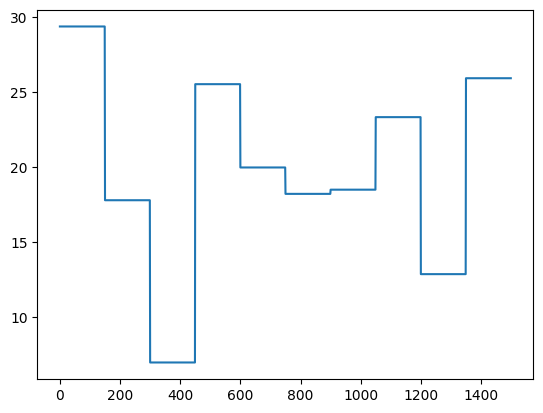

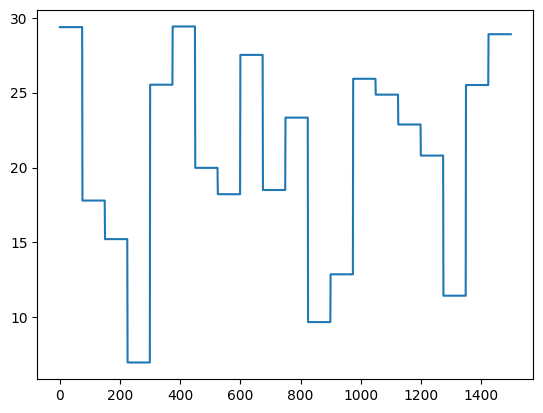

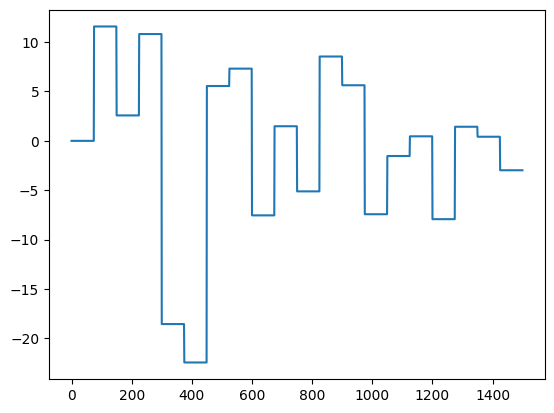

In [ ]:
# plt.plot(input_1)
# plt.show()
# plt.plot(input_2)
# plt.show()
# plt.plot(input_1-input_2)
# plt.show()